In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
batch_size = 64
train_dataset = MNIST(root="./datasets", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print(f"Training samples: {len(train_dataset)}")


test_dataset = MNIST(root="./datasets", train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Testing samples: {len(test_dataset)}")


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.04MB/s]

Training samples: 60000
Testing samples: 10000


### Let's display some images

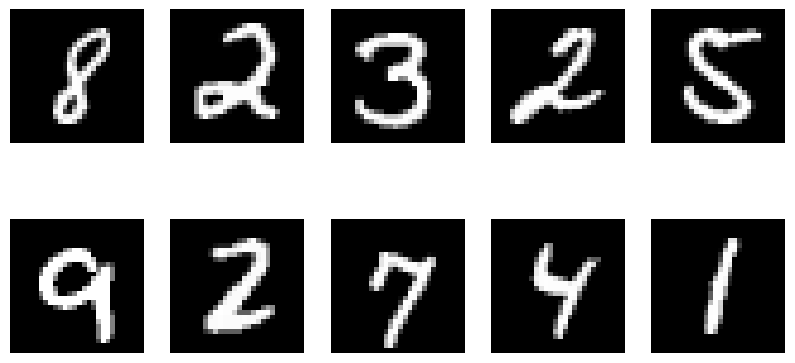

Shape of one image tensor: torch.Size([1, 28, 28])


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Getting a batch of training data
images, _ = next(iter(train_loader))  # Labels are ignored in Autoencoder

# Show images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    img = images[i]

    ax.imshow(img.permute(1,2,0).numpy(), cmap="gray")
    ax.axis("off")

plt.show()

# Show shape of one image
print("Shape of one image tensor:", images[0].shape)  # Expected: (1, 28, 28)


##Autoencoder Model


In [5]:
class CNNAutoEncoder(nn.Module):
    def __init__(self, encoding_dim=8):
        super(CNNAutoEncoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1),  # 28x28 -> 14x14
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, 3, 2, 1), # 14x14 -> 7x7
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, encoding_dim),
            nn.BatchNorm1d(encoding_dim),
            nn.Tanh(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32 * 7 * 7),
            nn.BatchNorm1d(32 * 7 * 7),
            nn.LeakyReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding=1),  # 7x7 -> 14x14
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 1, 3, 2, 1, output_padding=1),   # 14x14 -> 28x28
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


##Training Function

In [6]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for images, _ in tqdm(dataloader):
        images = images.to(device)

        _, reconstructions = model(images)
        loss = criterion(reconstructions, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


##Testing Function

In [7]:
def test_one_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)

            _, reconstructions = model(images)
            loss = criterion(reconstructions, images)

            total_loss += loss.item()

    return total_loss / len(dataloader)


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNNAutoEncoder(encoding_dim=8).to(device)
print(model)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
num_epochs = 20

train_losses = []
test_losses = []


CNNAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1568, out_features=8, bias=True)
    (8): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=1568, bias=True)
    (1): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Unflatten(dim=1, unflattened_size=(32, 7, 7))
    (4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), p

##Train & Test Loop

In [9]:
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    test_loss = test_one_epoch(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")


100%|██████████| 938/938 [00:12<00:00, 76.11it/s]


Epoch 1/20, Train Loss = 0.1132, Test Loss = 0.0684


100%|██████████| 938/938 [00:10<00:00, 86.82it/s]


Epoch 2/20, Train Loss = 0.0536, Test Loss = 0.0425


100%|██████████| 938/938 [00:10<00:00, 89.61it/s]


Epoch 3/20, Train Loss = 0.0391, Test Loss = 0.0344


100%|██████████| 938/938 [00:10<00:00, 89.03it/s]


Epoch 4/20, Train Loss = 0.0339, Test Loss = 0.0307


100%|██████████| 938/938 [00:10<00:00, 89.78it/s]


Epoch 5/20, Train Loss = 0.0313, Test Loss = 0.0286


100%|██████████| 938/938 [00:10<00:00, 90.52it/s]


Epoch 6/20, Train Loss = 0.0298, Test Loss = 0.0272


100%|██████████| 938/938 [00:11<00:00, 85.12it/s]


Epoch 7/20, Train Loss = 0.0286, Test Loss = 0.0262


100%|██████████| 938/938 [00:10<00:00, 93.04it/s]


Epoch 8/20, Train Loss = 0.0278, Test Loss = 0.0253


100%|██████████| 938/938 [00:09<00:00, 95.62it/s]


Epoch 9/20, Train Loss = 0.0271, Test Loss = 0.0248


100%|██████████| 938/938 [00:12<00:00, 76.53it/s]


Epoch 10/20, Train Loss = 0.0266, Test Loss = 0.0242


100%|██████████| 938/938 [00:10<00:00, 86.02it/s]


Epoch 11/20, Train Loss = 0.0262, Test Loss = 0.0239


100%|██████████| 938/938 [00:10<00:00, 91.37it/s]


Epoch 12/20, Train Loss = 0.0257, Test Loss = 0.0234


100%|██████████| 938/938 [00:09<00:00, 94.75it/s]


Epoch 13/20, Train Loss = 0.0255, Test Loss = 0.0231


100%|██████████| 938/938 [00:09<00:00, 94.53it/s]


Epoch 14/20, Train Loss = 0.0252, Test Loss = 0.0227


100%|██████████| 938/938 [00:10<00:00, 93.66it/s]


Epoch 15/20, Train Loss = 0.0249, Test Loss = 0.0225


100%|██████████| 938/938 [00:10<00:00, 92.85it/s]


Epoch 16/20, Train Loss = 0.0247, Test Loss = 0.0222


100%|██████████| 938/938 [00:10<00:00, 91.05it/s]


Epoch 17/20, Train Loss = 0.0245, Test Loss = 0.0220


100%|██████████| 938/938 [00:10<00:00, 88.75it/s]


Epoch 18/20, Train Loss = 0.0243, Test Loss = 0.0219


100%|██████████| 938/938 [00:10<00:00, 87.74it/s]


Epoch 19/20, Train Loss = 0.0242, Test Loss = 0.0217


100%|██████████| 938/938 [00:10<00:00, 87.18it/s]


Epoch 20/20, Train Loss = 0.0240, Test Loss = 0.0215


##Plot Training and Testing Loss Curves

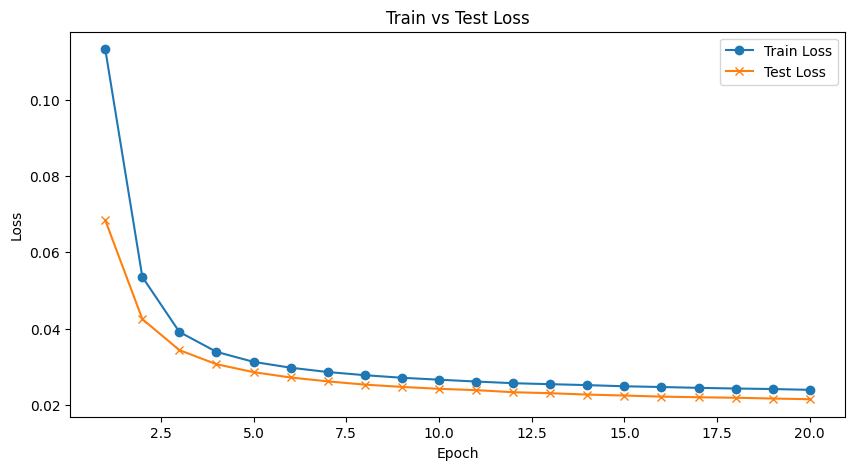

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), test_losses, label="Test Loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.show()


##Original vs Reconstructed Image




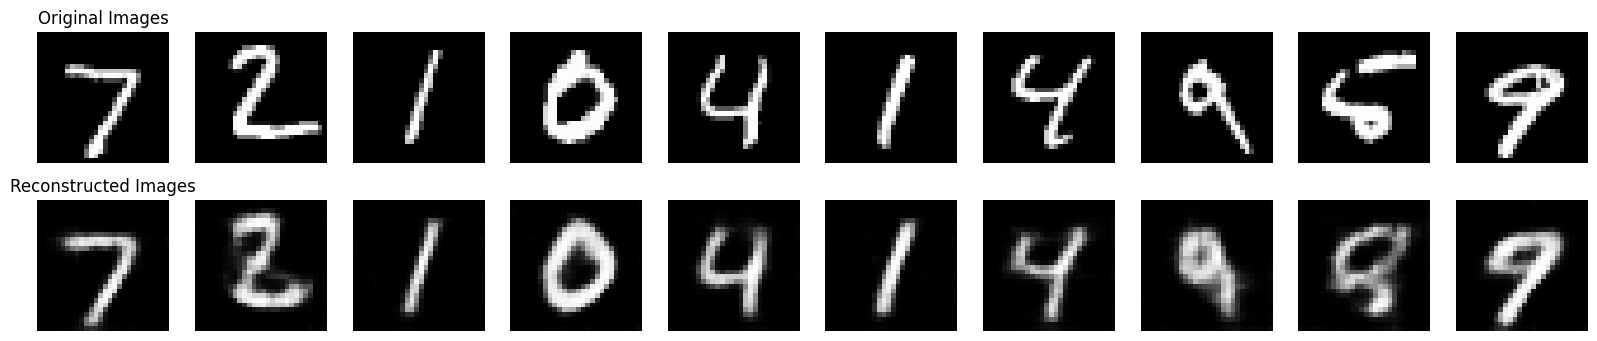

In [11]:
def show_original_vs_reconstructed(model, dataloader, device, num_images=10):
    model.eval()
    images, _ = next(iter(dataloader))
    images = images[:num_images].to(device)

    with torch.no_grad():
        _, reconstructions = model(images)
    reconstructions = reconstructions.cpu()

    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
    for i in range(num_images):
        axes[0, i].imshow(images[i].cpu().permute(1,2,0), cmap="gray")
        axes[0, i].axis("off")

        axes[1, i].imshow(reconstructions[i].permute(1,2,0), cmap="gray")
        axes[1, i].axis("off")

    axes[0, 0].set_title("Original Images", fontsize=12)
    axes[1, 0].set_title("Reconstructed Images", fontsize=12)
    plt.show()

show_original_vs_reconstructed(model, test_loader, device)


##Generating New Images from Random Encodings


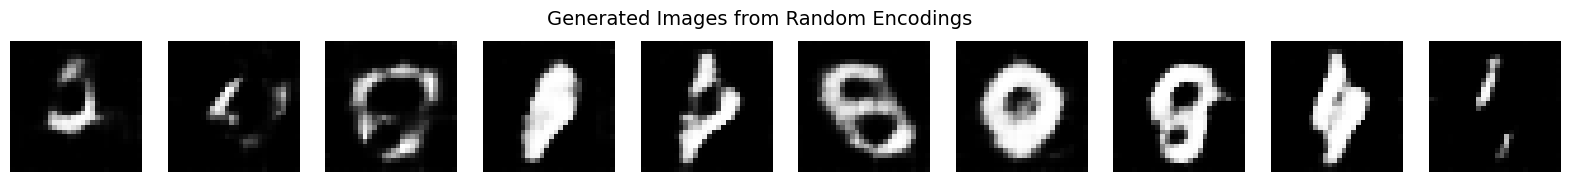

In [20]:
def generate_images(model, num_images=10, encoding_dim=8):
    model.eval()
    random_encodings = (torch.rand(num_images, encoding_dim).to(device) - 0.5) * 2

    with torch.no_grad():
        generated_images = model.decoder(random_encodings).cpu()

    generated_images = generated_images.view(-1, 28, 28)

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i], cmap="gray")
        ax.axis("off")

    plt.suptitle("Generated Images from Random Encodings", fontsize=14)
    plt.show()

generate_images(model, num_images=10, encoding_dim=8)


##Done🔥😊